In [129]:
import glob
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy import misc
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [199]:
# %load functions.py

from functions6 import *

In [186]:
images = glob.glob('non-vehicles/**/*.png')
images2 = glob.glob('vehicles/**/*.png')
cars = []
notcars = []

for image in images:
    notcars.append(image)
    
for image in images2:
    cars.append(image)

In [187]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [188]:
#ystart = 400
#ystop = 656
#scale = 1.5
scales         = [1, 1.5, 2]
y_start_stop  = [[380, 460], [380, 560], [380, 620]]

In [189]:
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

100%|██████████████████████████████████████████████████████████████████████████████| 8968/8968 [01:42<00:00, 87.77it/s]


225.11 Seconds to extract HOG features...


In [200]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#parameters = {'C':[10]}
svr = svm.SVC(kernel='rbf', C=10)
#clf = GridSearchCV(svr, parameters)
svr.fit(X_train, y_train)

# Use a linear SVC 
'''svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)'''
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
424.79 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
My SVC predicts:  [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
For these 10 labels:  [1. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
0.04253 Seconds to predict 10 labels with SVC


In [206]:
def pipeline(image):
    boxes_list, out_img = find_cars(image,y_start_stop, scales, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img,heatmap

Pix per cell  8
Cell per block  2
Pix per cell  8
Cell per block  2
Pix per cell  8
Cell per block  2


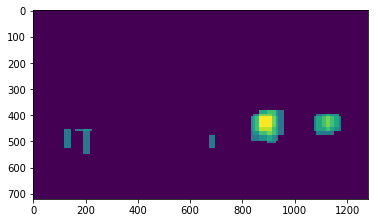

In [210]:
image = mpimg.imread('test_images/test6.jpg')
img, heatmap = pipeline(image)

plt.imshow(heatmap)
#plt.imshow(img)

#cv2.imwrite('output_images/test2.jpg',img)

In [87]:
image = mpimg.imread('test_images/test6.jpg')
boxes_list, out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

In [94]:

heat = np.zeros_like(image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,boxes_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

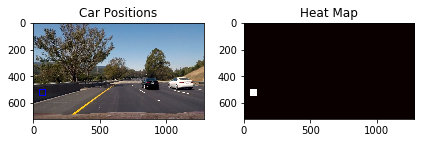

In [95]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [100]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4").subclip(0,2)
write_clip = clip1.fl_image(pipeline)
%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [06:11<00:07,  7.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 6min 13s
